### Import Necessary Libraries

In [10]:
from pyspark.sql import SparkSession
import pyspark.pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, TimestampType, DoubleType
from pyspark.sql.functions import to_date,from_unixtime, unix_timestamp, col, datediff, lit, array
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler,VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans, BisectingKMeans
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import functions as F

### Creating a Spark Object

In [2]:
spark = SparkSession.builder.getOrCreate()

23/08/25 14:01:22 WARN Utils: Your hostname, myUbuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.149 instead (on interface wlo1)
23/08/25 14:01:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/25 14:01:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading the Data Set 

1. As we have the header already in the dataset.
2. We have **header** as **true** in the below code, as well as initially we are letting spark object decide the schema as well, hence **infershema** is **True** as well

In [3]:
csv_file_path = r"/home/hadoop/CustomerSegmentation/BankCustomerSegmentation/bank_transactions.csv"
sdf = spark.read.option("header","true").csv(csv_file_path, inferSchema = True)

### Creating a a backup data set of the original one right at the start

In [4]:
backup_df = sdf# creating a Backup

#### Changing the type of CustomerDOB as the infershcema was not able to identify the column as a DateType()

In [5]:
sdf = sdf.withColumn("CustomerDOB",sdf["CustomerDOB"].cast(DateType()))   # Converting the CustomerDOB to DateType()
sdf.show(5)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|           T1|  C5841053| 1994-01-10|         F|  JAMSHEDPUR|          17819.05|     2016-08-02|         143207|                   25.0|
|           T2|  C2142763| 1957-04-04|         M|     JHAJJAR|           2270.69|     2016-08-02|         141858|                27999.0|
|           T3|  C4417068| 1996-11-26|         F|      MUMBAI|          17874.44|     2016-08-02|         142712|                  459.0|
|           T4|  C5342380| 1973-09-14|         F|      MUMBAI|         866503.21|     2016-08-02|         142714|                 2060.0|
|           T5|  C9031234| 1988-03

#### We are creating a list of numberical columns with List Comprehension in the below step, the aim is to use the describe method on all the numerical columns

In [6]:
numeric_columns = sdf.select([col for col, dtype in sdf.dtypes if dtype == "double" or dtype == "int"])
numeric_columns.describe().show()

+-------+------------------+------------------+-----------------------+
|summary|CustAccountBalance|   TransactionTime|TransactionAmount (INR)|
+-------+------------------+------------------+-----------------------+
|  count|           1046198|           1048567|                1048567|
|   mean| 115403.5400562223|157087.52939297154|     1574.3350034571101|
| stddev| 846485.3806006606| 51261.85402232943|      6574.742978454006|
|    min|               0.0|                 0|                    0.0|
|    max|     1.150354951E8|            235959|             1560034.99|
+-------+------------------+------------------+-----------------------+



### We can afford to remove the NaN values, as the column with highest number of null value only consists of 5.5 percent of null values

In [11]:
null_counts = sdf.agg(*[F.sum(F.col(column).isNull().cast("int")).alias(column) for column in sdf.columns])
null_counts.show()

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|            0|         0|      60736|      1100|         151|              2369|              0|              0|                      0|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+



In [7]:
print(f"Shape before dropping the na values : ({sdf.count()},{len(sdf.columns)})")
sdf = sdf.na.drop()
print(f"Shape after dropping the na values : ({sdf.count()},{len(sdf.columns)})")
sdf.show(truncate=False)

Shape before dropping the na values : (1048567,9)


#### Here as we have the birth date, we will calculate the age of the Customer at the time he made the transaction 
#####  TransactionDate - CustomerDate = No. of days (Will give us number of days between the 2 Date Columns)
#####  No. of Days / 365 - is going to give us float of years 
#####  Casting it to the IntegerType  as the age is always said to be as a whole Number
#####  As now we are creating a correlated column of Age, we should drop the CustomerDOB column for reducing the Multicolliearity 

In [11]:
sdf = sdf.withColumn('CustomerAge', datediff('TransactionDate','CustomerDOB')/365)
sdf = sdf.withColumn('CustomerAge', col('CustomerAge').cast(IntegerType()))
sdf.show()
sdf = sdf.drop("CustomerDOB")

### Now let us try to acheive the Encoding in a few specific columns.

##### StringIndexer comes in handy for PySpark if we need to have Numbers(Float Values) assigned to Strings
##### Again now we can go ahead and drop the CustGender Column

#### Encoding the CustGender column

In [39]:
indexer = StringIndexer(inputCol='CustGender', outputCol='GenderEncoded')
sdf = indexer.fit(sdf).transform(sdf)
sdf = sdf.withColumn('GenderEncoded', col('GenderEncoded').cast(IntegerType()))
sdf = sdf.drop("CustGender")
sdf.show()
sdf.show(truncate = False)

Py4JJavaError: An error occurred while calling o987234.fit.
: org.apache.spark.SparkException: Input column CustGender does not exist.
	at org.apache.spark.ml.feature.StringIndexerBase.$anonfun$validateAndTransformSchema$2(StringIndexer.scala:128)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.mutable.ArrayOps$ofRef.flatMap(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema(StringIndexer.scala:123)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema$(StringIndexer.scala:115)
	at org.apache.spark.ml.feature.StringIndexer.validateAndTransformSchema(StringIndexer.scala:145)
	at org.apache.spark.ml.feature.StringIndexer.transformSchema(StringIndexer.scala:252)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:237)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [38]:
sdf.groupBy("GenderEncoded").count().show() # To check the the distribution of Gender with respect to the number of transactions done!

+-------------+------+
|GenderEncoded| count|
+-------------+------+
|            1|272868|
|            0|712454|
+-------------+------+



#### Endcoding the CustLocation Column

In [20]:
indexer_location = StringIndexer(inputCol='CustLocation', outputCol='LocationEncoded')
sdf = indexer_location.fit(sdf).transform(sdf)
sdf = sdf.withColumn('LocationEncoded', col('LocationEncoded').cast(IntegerType()))
sdf = sdf.drop("CustLocation")
sdf.show()

In [23]:
ip_columns = ['CustAccountBalance', 'TransactionTime','TransactionAmount (INR)','CustomerAge','LocationEncoded']
# Assemble features into a Vector column
assembler = VectorAssembler(inputCols=ip_columns, outputCol="features")
df = assembler.transform(sdf)


scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features") # Initialize the MinMaxScaler

# Fit and transform the data using the scaler
scaler_model = scaler.fit(df)
scaled_df = scaler_model.transform(df)

# Show the scaled data
scaled_df.show(truncate=False)



+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+-------------------------------------+---------------------------------------------------------------------------------------------------------+
|TransactionID|CustomerID|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustomerAge|GenderEncoded|LocationEncoded|features                             |scaled_features                                                                                          |
+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+-------------------------------------+---------------------------------------------------------------------------------------------------------+
|T1           |C5841053  |17819.05          |2016-08-02     |143207         |25.0                   |22         |1            |61       

In [24]:
scaled_df.show()

+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+--------------------+--------------------+
|TransactionID|CustomerID|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustomerAge|GenderEncoded|LocationEncoded|            features|     scaled_features|
+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+--------------------+--------------------+
|           T1|  C5841053|          17819.05|     2016-08-02|         143207|                   25.0|         22|            1|             61|[17819.05,143207....|[1.54900450374121...|
|           T2|  C2142763|           2270.69|     2016-08-02|         141858|                27999.0|         59|            0|            106|[2270.69,141858.0...|[1.97390379206530...|
|           T3|  C4417068|          17874.44|     2016-08-02|         

In [25]:
final_data = scaled_df.drop("CustAccountBalance","TransactionDate","TransactionTime","TransactionAmount (INR)","CustomerAge","LocationEncoded","LocationEncoded","features")

In [26]:
final_data = final_data.drop("TransactionID","CustomerID")

23/08/25 02:03:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


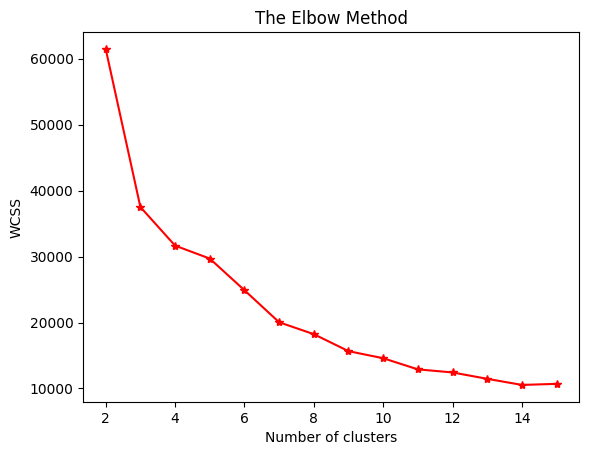

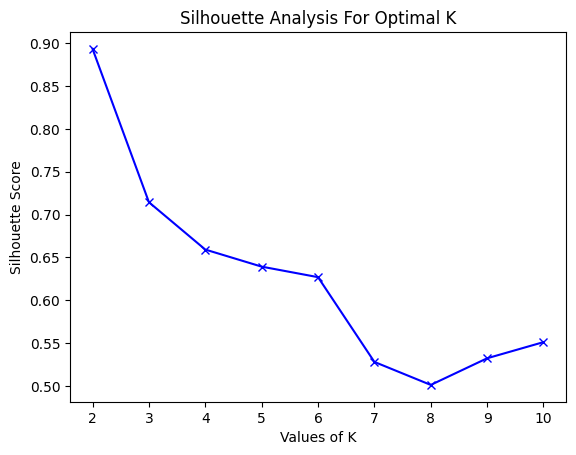

In [27]:
# Select the features to be used for clustering and assemble them into a vector column
feature_cols = ["GenderEncoded", "scaled_features"]  # Replace with your feature column names
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(final_data)
data.drop("features")
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(2, 16):
    kmeans = KMeans().setK(i).setSeed(42)
    model = kmeans.fit(data)
    wcss.append(model.summary.trainingCost)  # Equivalent to Sklearns ._inertia

# Plot the Elbow Method graph
plt.plot(range(2, 16), wcss, marker='*', color='r')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


# Calculate Silhouette scores for different numbers of clusters
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []
for num_clusters in range_n_clusters:
    kmeans = KMeans().setK(num_clusters).setSeed(42)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plot the Silhouette Analysis graph
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal K')
plt.show()

In [36]:
data_with_cluster = data.withColumn("Cluster", array([lit(val) for val in cluster_assignments]))

# Show the DataFrame with the new column
data_with_cluster.show()

23/08/25 02:40:20 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


+-------------+--------------------+--------------------+--------------------+
|GenderEncoded|     scaled_features|            features|             Cluster|
+-------------+--------------------+--------------------+--------------------+
|            1|[1.54900450374121...|[1.0,1.5490045037...|[0, 1, 0, 0, 0, 0...|
|            0|[1.97390379206530...|[0.0,1.9739037920...|[0, 1, 0, 0, 0, 0...|
|            1|[1.55381953930496...|[1.0,1.5538195393...|[0, 1, 0, 0, 0, 0...|
|            1|[0.00753248559713...|[1.0,0.0075324855...|[0, 1, 0, 0, 0, 0...|
|            1|[5.83683322626913...|[1.0,5.8368332262...|[0, 1, 0, 0, 0, 0...|
|            1|[4.66023117068324...|[1.0,4.6602311706...|[0, 1, 0, 0, 0, 0...|
|            1|[8.46225766363481...|[1.0,8.4622576636...|[0, 1, 0, 0, 0, 0...|
|            0|[8.26488727825712...|[0.0,8.2648872782...|[0, 1, 0, 0, 0, 0...|
|            1|[1.29585742096745...|[1.0,1.2958574209...|[0, 1, 0, 0, 0, 0...|
|            0|[3.71991270718667...|[0.0,3.719912707

In [34]:
cluster_df = spark.createDataFrame([(val,) for val in cluster_assignments], ["Cluster"])

# Join cluster_df with data based on the row number
data_with_cluster = data.withColumn("row_num", F.monotonically_increasing_id())
clustered_data = data_with_cluster.join(cluster_df, on="row_num").drop("row_num")

# Show the DataFrame with the new column
clustered_data.show()

AnalysisException: [UNRESOLVED_USING_COLUMN_FOR_JOIN] USING column `row_num` cannot be resolved on the right side of the join. The right-side columns: [`Cluster`].

In [31]:
data.count()

985322

In [29]:
data = data.withColumn("Cluster", F.expr(f"array({','.join(map(str, cluster_assignments))})"))

PySparkTypeError: [NOT_COLUMN] Argument `col` should be a Column, got list.

In [75]:
# Train a BisectingKMeans model
k = 2  # Number of clusters
bkm = BisectingKMeans().setK(k).setSeed(42)
model = bkm.fit(data)

# Transform the data with cluster assignments
clustered_data = model.transform(data)

# Display the clustered data
clustered_data.show()

+-------------+--------------------+--------------------+----------+
|GenderEncoded|     scaled_features|            features|prediction|
+-------------+--------------------+--------------------+----------+
|            1|[1.54900450374121...|[1.0,1.5490045037...|         1|
|            0|[1.97390379206530...|[0.0,1.9739037920...|         0|
|            1|[1.55381953930496...|[1.0,1.5538195393...|         1|
|            1|[0.00753248559713...|[1.0,0.0075324855...|         1|
|            1|[5.83683322626913...|[1.0,5.8368332262...|         1|
|            1|[4.66023117068324...|[1.0,4.6602311706...|         1|
|            1|[8.46225766363481...|[1.0,8.4622576636...|         1|
|            0|[8.26488727825712...|[0.0,8.2648872782...|         0|
|            1|[1.29585742096745...|[1.0,1.2958574209...|         1|
|            0|[3.71991270718667...|[0.0,3.7199127071...|         0|
|            0|[4.20996058285317...|[0.0,4.2099605828...|         0|
|            0|[1.27034355676885..

In [78]:
data

+-------------+---------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|GenderEncoded|scaled_features                                                                                          |features                                                                                                     |
+-------------+---------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|1            |[1.5490045037412108E-4,0.6069147606151917,1.6025281586793128E-5,0.3535353535353536,0.007472742864143085] |[1.0,1.5490045037412108E-4,0.6069147606151917,1.6025281586793128E-5,0.3535353535353536,0.007472742864143085] |
|0            |[1.9739037920653066E-5,0.6011976656961592,0.0179476743659